In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor

In [27]:
csv_path = Path("Housing.csv")
df = pd.read_csv(csv_path)
target_col = "price"
y = df[target_col].values
X = df.drop(columns=[target_col, "rownames"])
X.head()


,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
0,5850,3,1,2,yes,no,yes,no,no,1,no
1,4000,2,1,1,yes,no,no,no,no,0,no
2,3060,3,1,1,yes,no,no,no,no,0,no
3,6650,3,1,2,yes,yes,no,no,no,0,no
4,6360,2,1,1,yes,no,no,no,no,0,no


In [28]:
y

array([ 42000,  38500,  49500,  60500,  61000,  66000,  66000,  69000,
        83800,  88500,  90000,  30500,  27000,  36000,  37000,  37900,
        40500,  40750,  45000,  45000,  48500,  65900,  37900,  38000,
        42000,  42300,  43500,  44000,  44500,  44900,  45000,  48000,
        49000,  51500,  61000,  61000,  61700,  67000,  82000,  54500,
        66500,  70000,  82000,  92000,  38000,  44000,  41000,  43000,
        48000,  54800,  55000,  57000,  68000,  95000,  38000,  25000,
        25245,  56000,  35500,  30000,  48000,  48000,  52000,  54000,
        56000,  60000,  60000,  67000,  47000,  70000,  45000,  51000,
        32500,  34000,  35000,  36000,  45000,  47000,  55000,  63900,
        50000,  35000,  50000,  43000,  55500,  57000,  60000,  78000,
        35000,  44000,  47000,  58000, 163000, 128000, 123500,  39000,
        53900,  59900,  35000,  43000,  57000,  79000, 125000, 132000,
        58000,  43000,  48000,  58500,  73000,  63500,  43000,  46500,
      

In [29]:
from sklearn.pipeline import Pipeline

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
reg = DecisionTreeRegressor(
    criterion="squared_error",
    random_state=42
)

pipeline = Pipeline([
    ("preprocess", preprocess),
    ("tree", reg)
])

param_grid = {
    "tree__max_depth": [3, 5, 7, None],
    "tree__min_samples_split": [2, 5, 10],
    "tree__min_samples_leaf": [1, 3, 5, 10]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  cv=cv,
                  scoring="neg_mean_squared_error",
                  n_jobs=-1,
                  verbose=0
                  )
gs.fit(X_train, y_train)
best_model = gs.best_estimator_
gs.best_params_



{'tree__max_depth': 7,
 'tree__min_samples_leaf': 1,
 'tree__min_samples_split': 10}

In [32]:
from sklearn.metrics import r2_score


def rmse(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)

y_pred = best_model.predict(X_test)
print(f"Target: {target_col}")
print(f"Best params: {gs.best_params_}")
print(f"R^2 (test): {r2_score(y_test, y_pred):.4f}")
print(f"RMSE (test): {rmse(y_test, y_pred):.2f}")

Target: price
Best params: {'tree__max_depth': 7, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 10}
R^2 (test): 0.2200
RMSE (test): 22827.87


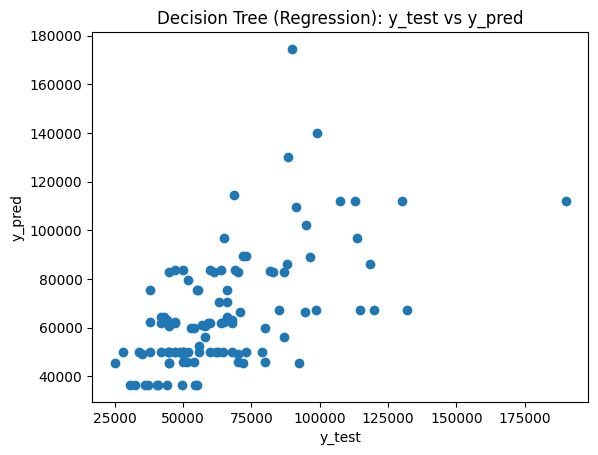

,feature,importance
0,lotsize,0.511984
2,bathrms,0.156663
4,garagepl,0.074492
13,airco_no,0.074192
3,stories,0.059459
9,fullbase_no,0.042915
1,bedrooms,0.022960
12,gashw_yes,0.022542
7,recroom_no,0.018471
15,prefarea_no,0.011425


In [35]:
# y_test vs y_pred
plt.figure()
plt.scatter(y_test, y_pred)
plt.title("Decision Tree (Regression): y_test vs y_pred")
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

# Имена признаков после one-hot
oh = None
if categorical_features:
    oh = best_model.named_steps["preprocess"].transformers_[1][1].named_steps["onehot"]
num_names = numeric_features
cat_names = oh.get_feature_names_out(categorical_features).tolist() if oh is not None else []
feature_names = num_names + cat_names

# Важности
importances = best_model.named_steps["tree"].feature_importances_
imp_df = (pd.DataFrame({
    "feature": feature_names if len(feature_names)==len(importances) else [f"f{i}" for i in range(len(importances))],
    "importance": importances
})
.sort_values("importance", ascending=False)
.head(10))

imp_df

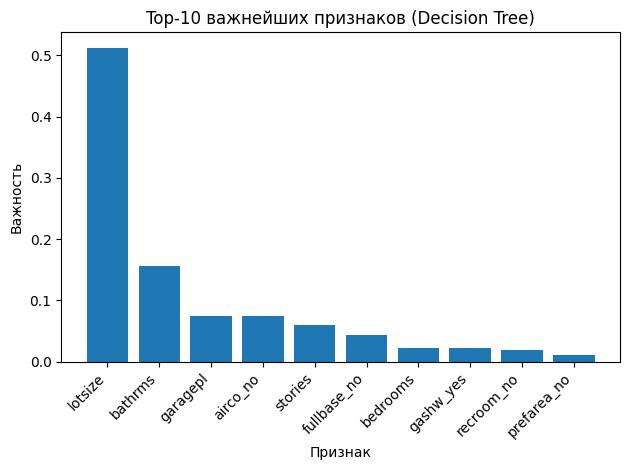

In [36]:
plt.figure()
plt.bar(imp_df["feature"], imp_df["importance"])
plt.title("Top-10 важнейших признаков (Decision Tree)")
plt.xlabel("Признак")
plt.ylabel("Важность")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()